<a href="https://colab.research.google.com/github/jdcneto/Modulation-Classificaton/blob/main/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modulation Recognition: RML2016.10a Dataset 


# Import Packages

In [1]:
# Import packages
%matplotlib inline
import _pickle as cPickle
import numpy as np
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#setting seed for reproducibility
seed = 10
np.random.seed(seed)
torch.manual_seed(seed);

# Dataset setup

In [4]:
# Load the dataset ...
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filename = "/content/drive/MyDrive/RML2016.10a_dict.dat"
open_file = open(filename,'rb')
Xd = cPickle.load(open_file, encoding='latin1')

In [5]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(X.shape)

(220000, 2, 128)


In [6]:
# Partition the data into train/test, 80% to train. while keeping SNR and Mod labels handy for each
n_examples = X.shape[0]
n_train = int(n_examples*.8)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [7]:
print(X_train.shape, X_test.shape)

(176000, 2, 128) (44000, 2, 128)


In [8]:
print('modulation labels: {}'.format(mods))

modulation labels: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [9]:
# separating labels
train_labels = np.array(list(map(lambda x: mods.index(lbl[x][0]), train_idx)), dtype=int)
test_labels  = np.array(list(map(lambda x: mods.index(lbl[x][0]), test_idx)), dtype=int)

In [10]:
print(train_labels.shape, test_labels.shape)

(176000,) (44000,)


In [11]:
# reshaping data - add one dimension
x_train = np.expand_dims(X_train, axis=1)
x_test  = np.expand_dims(X_test, axis=1)
print(x_train.shape, x_test.shape )

(176000, 1, 2, 128) (44000, 1, 2, 128)


In [12]:
# data loader to feed cnn model
x_train, x_test = torch.Tensor(x_train), torch.Tensor(x_test)
y_train, y_test = torch.Tensor(train_labels), torch.Tensor(test_labels)
 
train_dataset = TensorDataset(x_train, y_train.type(torch.LongTensor))
test_dataset  = TensorDataset(x_test, y_test.type(torch.LongTensor))

In [13]:
batch_size = 2048
TrainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
TestLoader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Building the CNN Model

In [14]:
# Dropout rate
dr = 0.5

In [16]:
# Build CNN model using Torch
class CovNet(nn.Module):
    def __init__(self):
        super(CovNet, self).__init__()
        self.conv1    = nn.Conv2d(1, 256, (1,7), padding=(0,3))
        #nn.init.xavier_uniform_(self.conv1.weight,gain=nn.init.calculate_gain('relu'))
        self.b1  = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(dr)
        self.conv2    = nn.Conv2d(256, 80, (2,7), padding=(0,3))
        #nn.init.xavier_uniform_(self.conv2.weight,gain=nn.init.calculate_gain('relu'))
        self.b2  = nn.BatchNorm2d(80)
        self.dropout2 = nn.Dropout(dr)
        self.fc1      = nn.Linear(80*128, 256)
        #nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.dropout3 = nn.Dropout(dr)
        self.fc2      = nn.Linear(256, len(mods))
        #nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='sigmoid')
      
    def forward(self, x):
          #x = self.zeropad1(x)
          x = F.relu(self.conv1(x))
          x= self.b1(x)
          x = self.dropout1(x)
          x = F.relu(self.conv2(x))
          x = self.dropout2(x)
          x= self.b2(x)
          x = x.view(-1, 80*128)
          x = F.relu(self.fc1(x))
          x = self.dropout3(x)
          out = self.fc2(x)
          # x = self.fc2(x)
          # out = F.log_softmax(self.fc2(x), dim=1)
          return out
          
cnn = CovNet().to(device=device)

In [17]:
summary(cnn, (1,2,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 2, 128]           2,048
       BatchNorm2d-2          [-1, 256, 2, 128]             512
           Dropout-3          [-1, 256, 2, 128]               0
            Conv2d-4           [-1, 80, 1, 128]         286,800
           Dropout-5           [-1, 80, 1, 128]               0
       BatchNorm2d-6           [-1, 80, 1, 128]             160
            Linear-7                  [-1, 256]       2,621,696
           Dropout-8                  [-1, 256]               0
            Linear-9                   [-1, 11]           2,827
Total params: 2,914,043
Trainable params: 2,914,043
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.74
Params size (MB): 11.12
Estimated Total Size (MB): 12.86
-------------------------------------

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [19]:
# creating dictionary for statistics
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [20]:
def cnn_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

# Traininig the Model

In [21]:
num_epochs = 50
min_val_loss = np.inf
for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times
    cnn.train()   
    train_epoch_loss = 0.0
    train_epoch_acc  = 0.0

    for batch_idx, (data, target) in enumerate(TrainLoader):
        
        data, target = data.to(device=device), target.to(device=device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, target)
        acc = cnn_acc(outputs, target)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()

        # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0.0
        val_epoch_acc = 0.0
        
        cnn.eval()
        for X_val_batch, y_val_batch in TestLoader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = cnn(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = cnn_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(TrainLoader))
    loss_stats['val'].append(val_epoch_loss/len(TestLoader))
    accuracy_stats['train'].append(train_epoch_acc/len(TrainLoader))
    accuracy_stats['val'].append(val_epoch_acc/len(TestLoader))
                              
    print(f'Epoch {epoch}:  | Train Loss: {train_epoch_loss/len(TrainLoader):.5f} | Val Loss: {val_epoch_loss/len(TestLoader):.5f} | Train Acc: {train_epoch_acc/len(TrainLoader):.3f} | Val Acc: {val_epoch_acc/len(TestLoader):.3f}')
    
    if min_val_loss > val_epoch_loss:
        min_val_loss = val_epoch_loss
          
        # Saving State Dict
        torch.save(cnn.state_dict(), 'saved_model.pth')

print('Finished Training')

Epoch 1:  | Train Loss: 1.75338 | Val Loss: 3.48891 | Train Acc: 35.151 | Val Acc: 17.636
Epoch 2:  | Train Loss: 1.43289 | Val Loss: 1.39242 | Train Acc: 45.802 | Val Acc: 46.227
Epoch 3:  | Train Loss: 1.37743 | Val Loss: 1.33613 | Train Acc: 47.302 | Val Acc: 48.818
Epoch 4:  | Train Loss: 1.34995 | Val Loss: 1.39578 | Train Acc: 48.314 | Val Acc: 47.318
Epoch 5:  | Train Loss: 1.32967 | Val Loss: 1.37069 | Train Acc: 48.826 | Val Acc: 47.955
Epoch 6:  | Train Loss: 1.31419 | Val Loss: 1.33099 | Train Acc: 49.465 | Val Acc: 49.455
Epoch 7:  | Train Loss: 1.30063 | Val Loss: 1.30545 | Train Acc: 49.802 | Val Acc: 50.318
Epoch 8:  | Train Loss: 1.29144 | Val Loss: 1.46380 | Train Acc: 50.174 | Val Acc: 45.591
Epoch 9:  | Train Loss: 1.27898 | Val Loss: 1.30257 | Train Acc: 50.628 | Val Acc: 49.955
Epoch 10:  | Train Loss: 1.27107 | Val Loss: 1.30625 | Train Acc: 50.709 | Val Acc: 49.591
Epoch 11:  | Train Loss: 1.26028 | Val Loss: 1.30201 | Train Acc: 51.279 | Val Acc: 50.227
Epoch 12

# Evaluate and Plot Model Performance

In [24]:
#loading 
model = CovNet().to(device=device)
model.load_state_dict(torch.load('saved_model.pth',map_location=device))
#model1.eval()

<All keys matched successfully>

In [38]:
for name, loader in [("train", TrainLoader), ("test", TestLoader)]:
  y_pred_list = []
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in loader:
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        y_pred_list.append(predicted.cpu().numpy())
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

  print("Accuracy {}: {:.2f}".format(name , correct / total))
y_pred = [y for x in y_pred_list for y in x]

Accuracy train: 0.56
Accuracy test: 0.51


## Plot Model Statistics 

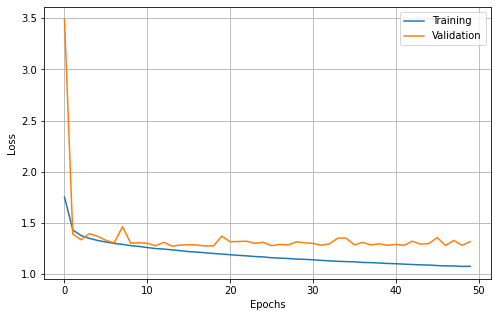

In [57]:
# Loss Figure plotting and saving figure
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(loss_stats['train'])
plt.plot(loss_stats['val'])
plt.legend(['Training','Validation'])
plt.ylabel('Loss'), plt.xlabel('Epochs')
plt.savefig('loss_curve.pdf'), plt.show();

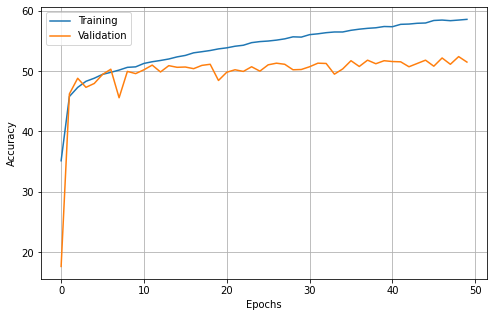

In [58]:
# Accuracy plotting and saving figure
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(accuracy_stats['train'])
plt.plot(accuracy_stats['val'])
plt.legend(['Training','Validation'])
plt.ylabel('Accuracy'), plt.xlabel('Epochs')
plt.savefig('acc_curve.pdf'), plt.show();

## Confusion Matrix and Classification Report

In [42]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(8,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

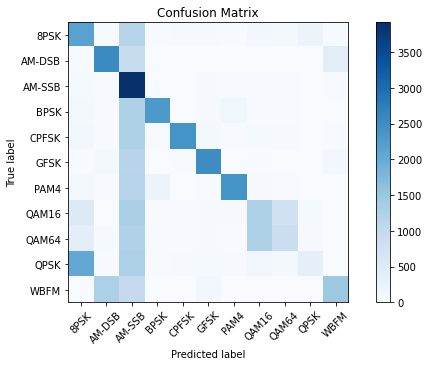

In [43]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plot_confusion_matrix(cm, labels=mods)

In [48]:
# Classification Report
report = classification_report(test_labels, y_pred, target_names=mods)
print(report)

              precision    recall  f1-score   support

        8PSK       0.39      0.55      0.46      3920
      AM-DSB       0.62      0.65      0.63      3943
      AM-SSB       0.25      0.95      0.39      4127
        BPSK       0.87      0.59      0.70      3926
       CPFSK       0.92      0.60      0.73      4028
        GFSK       0.86      0.63      0.73      3978
        PAM4       0.88      0.60      0.71      4048
       QAM16       0.43      0.31      0.36      4080
       QAM64       0.45      0.22      0.30      3969
        QPSK       0.48      0.08      0.14      4074
        WBFM       0.70      0.38      0.49      3907

    accuracy                           0.51     44000
   macro avg       0.62      0.51      0.51     44000
weighted avg       0.62      0.51      0.51     44000

